In [ ]:
%load_ext autoreload
%autoreload 

In [59]:
from src import config

from types import SimpleNamespace
from pathlib import Path
import wandb

from monai.data import (Dataset, DataLoader)

In [2]:
import os
import tarfile
import shutil
import tempfile
import time
import pickle
import matplotlib.pyplot as plt
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader, decollate_batch
from monai.handlers.utils import from_engine
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import SegResNet
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
)
from monai.utils import set_determinism

import torch
import torch.nn.parallel
import torch.distributed as dist

print_config()

MONAI version: 1.2.0
Numpy version: 1.25.0
Pytorch version: 2.0.1+cpu
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: c33f1ba588ee00229a309000e888f9817b4f1934
MONAI __file__: c:\Users\Cecilia\AppData\Local\pypoetry\Cache\virtualenvs\unsup-seg-gbm-nLgqUjZ0-py3.11\Lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.1.0
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 10.0.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.0.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
py

In [3]:
set_determinism(seed=0)

In [40]:
# Get train and validation dataset.
# train_files and val_files are a List[Dict] ->[{'image':[paths of MRI volumes], 'label':[path of label volume]}
modalities=['FLAIR.','T1.','T1GD.','T2.',]

train_files= get_file_data_label(config.DATA_TRAIN, config.LABEL_TRAIN, modalities)
val_files=get_file_data_label(config.DATA_TEST, config.LABEL_TEST, modalities)

print('Number of Train cases:',len(train_files))
print('Number of Modalities by cases:',len(train_files[0]['image']))
print('Number of Validation cases:',len(val_files))
print('Number of Modalities by cases:',len(val_files[0]['image']))

Number of Train cases: 10
Number of Modalities by cases: 4
Number of Validation cases: 1
Number of Modalities by cases: 4


In [77]:
class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """
    Convert labels to multi channels based on brats classes:
    label 1 is the peritumoral edema
    label 2 is the GD-enhancing tumor
    label 3 is the necrotic and non-enhancing tumor core
    The possible classes are TC (Tumor core), WT (Whole tumor)
    and ET (Enhancing tumor).

    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            # merge label 2 and label 3 to construct TC
            #result.append(torch.logical_or(d[key] == 2, d[key] == 3))
            result.append(d[key] == 2)
            # merge labels 1, 2 and 3 to construct WT
            #result.append(torch.logical_or(torch.logical_or(d[key] == 2, d[key] == 3), d[key] == 1))
            result.append(d[key] == 1)
            # label 2 is ET
            result.append(d[key] == 3)
            d[key] = torch.stack(result, axis=0).float()
        return d

In [103]:
train_transform = Compose(
    [
        # load 4 Nifti images and stack them together
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        RandSpatialCropd(keys=["image", "label"], roi_size=[224, 224, 144], random_size=False),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
    ]
)
val_transform = Compose(
    [
        LoadImaged(keys=["image", "label"],allow_missing_keys=True),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)

c:\Users\Cecilia\AppData\Local\pypoetry\Cache\virtualenvs\unsup-seg-gbm-nLgqUjZ0-py3.11\Lib\site-packages\monai\utils\deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)


In [104]:
# here we don't cache any data in case out of memory issue
root_dir=config.RAW_DATA_SET
train_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=train_transform,
    section="training",
    download=False,
    cache_rate=0.0,
    num_workers=4,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=4)
val_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=val_transform,
    section="validation",
    download=False,
    cache_rate=0.0,
    num_workers=4,
)
val_loader = DataLoader(val_ds, batch_size=2, shuffle=False, num_workers=4)

In [45]:
# Create iterable Dataset and its Dataloader for Data train
train_ds = Dataset(data=train_files,transform=train_transform, )
train_loader = DataLoader(train_ds, batch_size=1, ) #num_workers=8

# Create iterable Dataset and its Dataloader for Data validation
val_ds = Dataset(data=val_files,transform=val_transform, )
val_loader = DataLoader(val_ds, batch_size=1,) #num_workers=8

image shape: torch.Size([4, 240, 240, 155])


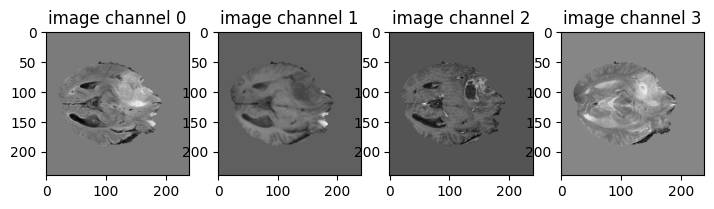

label shape: torch.Size([3, 240, 240, 155])


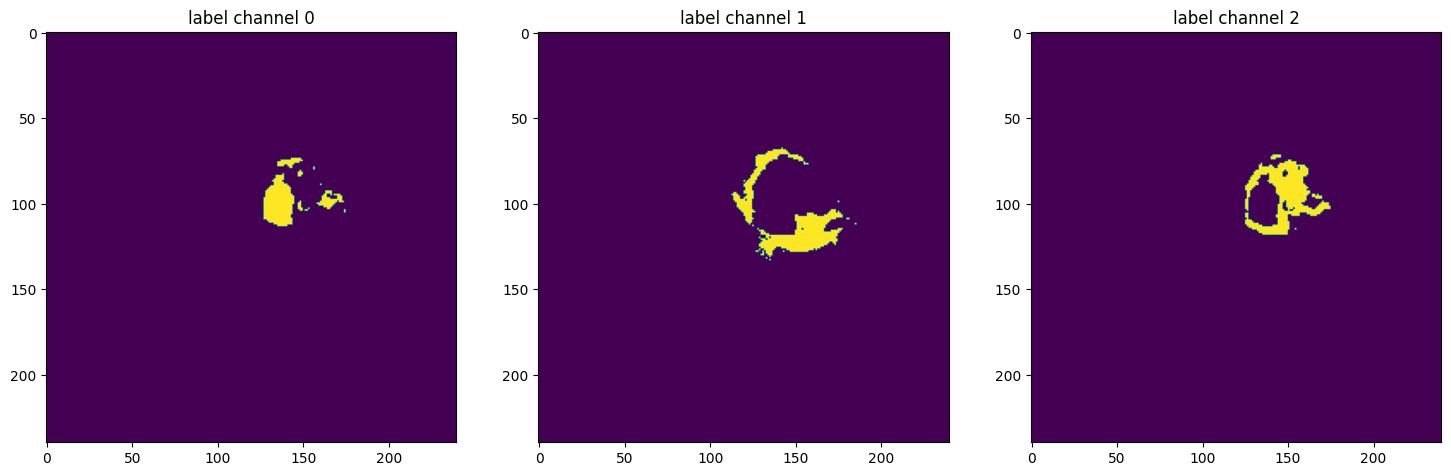

In [8]:
# pick one case from validation dataset to visualize and check the 11 channels
sl = 60
idx=1
val_data_example = val_ds[idx]
print(f"image shape: {val_data_example['image'].shape}")
plt.figure("image", (24, 6))
for i in range(val_data_example['image'].shape[0]):
    plt.subplot(1, 11, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(val_data_example["image"][i, :, :, sl].detach().cpu(), cmap="gray")
plt.show()

# also visualize the 3 channels label corresponding to this case
print(f"label shape: {val_data_example['label'].shape}")
plt.figure("label", (18, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(f"label channel {i}")
    plt.imshow(val_data_example["label"][i, :, :, sl].detach().cpu())
plt.show()

image shape: torch.Size([4, 224, 224, 144])


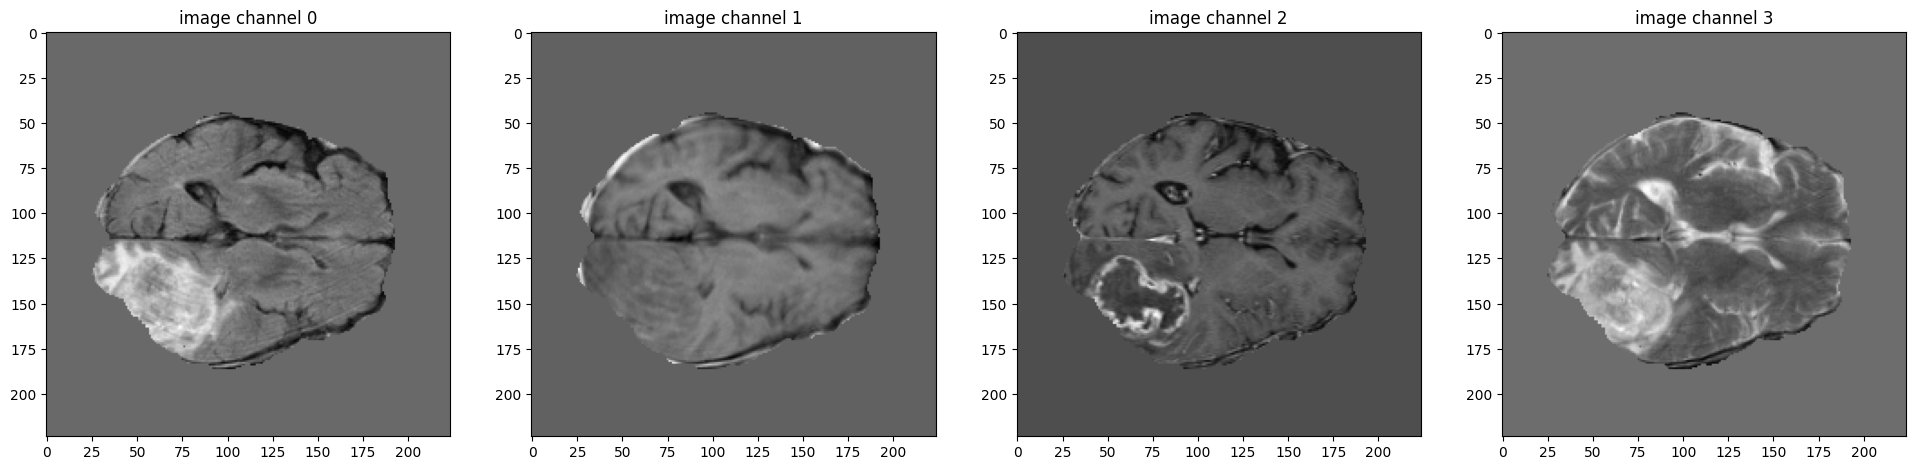

label shape: torch.Size([3, 224, 224, 144])


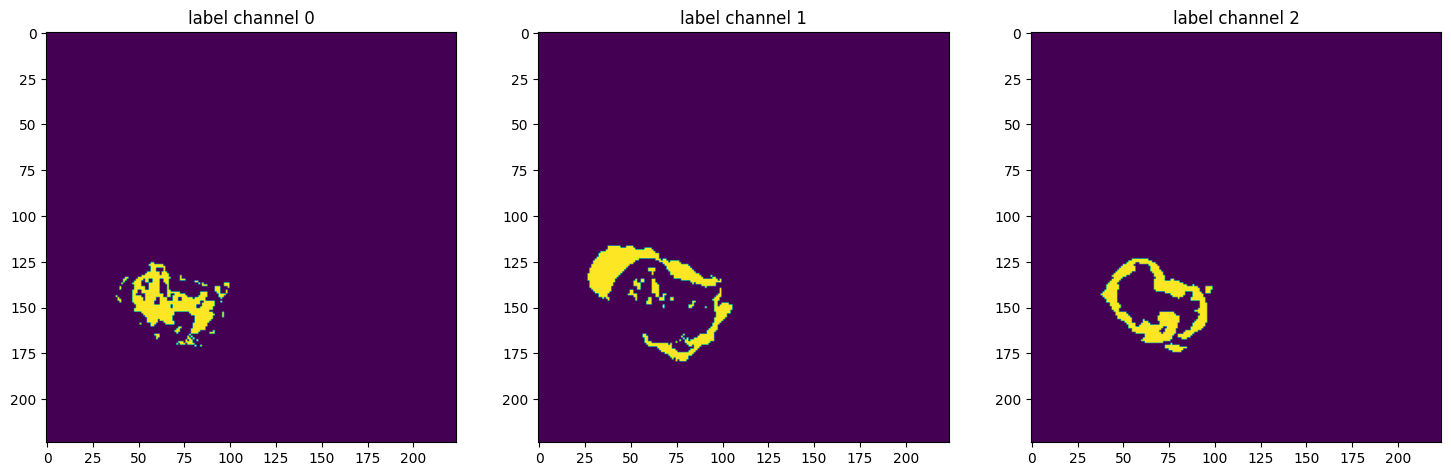

In [9]:
# pick one image from DecathlonDataset to visualize and check the 4 channels
val_data_example = train_ds[300]
sl=70
print(f"image shape: {val_data_example['image'].shape}")
plt.figure("image", (24, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(val_data_example["image"][i, :, :, sl].detach().cpu(), cmap="gray")
plt.show()
# also visualize the 3 channels label corresponding to this image
print(f"label shape: {val_data_example['label'].shape}")
plt.figure("label", (18, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(f"label channel {i}")
    plt.imshow(val_data_example["label"][i, :, :, sl].detach().cpu())
plt.show()

In [10]:
# Select device gpu or cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)
#!nvidia-smi

Device: cpu


In [12]:
wandb.login(anonymous="allow")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: (1) Private W&B dashboard, no account required
wandb: (2) Use an existing W&B account
wandb: You chose 'Use an existing W&B account'
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Cecilia/.netrc


True

In [38]:
#DATA_DIR = Path('./data/')
SAVE_DIR = root_dir
#SAVE_DIR.mkdir(exist_ok=True, parents=True)
DEVICE = device

config_train = SimpleNamespace(
    
    # network hyperparameters
    init_filters=16,
    dropout_prob=0.2,
    
    # training hyperparameters
    max_epochs = 100,
    lrate=1e-4, #0.00008644843137107063,
    weight_decay=1e-5,
    batch_size=1,
    
    # Post
    threshold=0.5,
    
    # Train type
    use_scaler = True,
    use_autocast = True,
)

In [39]:

run = wandb.init()
artifact = run.use_artifact('mlops-team89/SegResNet_BraTS_Kaggle_/jnpobo6c_best_model:v12', type='model')
artifact_dir = artifact.download()

wandb:   1 of 1 files downloaded.  


In [40]:

metrics = run.use_artifact('mlops-team89/SegResNet_BraTS_Kaggle_/jnpobo6c_metrics:v12', type='metrics')
metrics_dir = metrics.download()

wandb:   1 of 1 files downloaded.  


In [42]:
max_epochs = config_train.max_epochs
val_interval = 1
if config_train.use_autocast:
    VAL_AMP = True
else:
    VAL_AMP= False
    
#last_epoch=24

# standard PyTorch program style: create SegResNet, DiceLoss and Adam optimizer
model = SegResNet(
    blocks_down=[1, 2, 2, 4],
    blocks_up=[1, 1, 1],
    init_filters=config_train.init_filters,
    in_channels=4,
    out_channels=3,
    dropout_prob=config_train.dropout_prob,
)

if torch.cuda.is_available() and torch.cuda.device_count() >= 2:
    model = nn.DataParallel(model)
    
model.to(device)

loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), config_train.lrate, weight_decay=config_train.weight_decay)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config_train.max_epochs)

dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=config_train.threshold)])


# define inference method
def inference(input, model):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(240, 240, 160),
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)


# use amp to accelerate training
scaler = torch.cuda.amp.GradScaler()
# enable cuDNN benchmark
torch.backends.cudnn.benchmark = True
   

c:\Users\Cecilia\AppData\Local\pypoetry\Cache\virtualenvs\unsup-seg-gbm-nLgqUjZ0-py3.11\Lib\site-packages\torch\cuda\amp\grad_scaler.py:120: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


In [43]:
# Carga los pesos entrenados desde el archivo .pt
# model.load_state_dict(torch.load(os.path.join(config.MODEL_PATH, "best_metric_model.pth"), map_location=torch.device('cpu')))

# Asegúrate de que el modelo esté en modo de evaluación
# model.eval()

checkpoint = torch.load(os.path.join(artifact_dir, 'best_metric_model.pth'), map_location=torch.device('cpu'))
model.load_state_dict(checkpoint)
model.eval()

SegResNet(
  (act_mod): ReLU(inplace=True)
  (convInit): Convolution(
    (conv): Conv3d(4, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
  )
  (down_layers): ModuleList(
    (0): Sequential(
      (0): Identity()
      (1): ResBlock(
        (norm1): GroupNorm(8, 16, eps=1e-05, affine=True)
        (norm2): GroupNorm(8, 16, eps=1e-05, affine=True)
        (act): ReLU(inplace=True)
        (conv1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        )
        (conv2): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        )
      )
    )
    (1): Sequential(
      (0): Convolution(
        (conv): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      )
      (1): ResBlock(
        (norm1): GroupNorm(8, 32, eps=1e-05, affine=True)
        (norm2): GroupNorm(8, 32, eps=1e-05, a

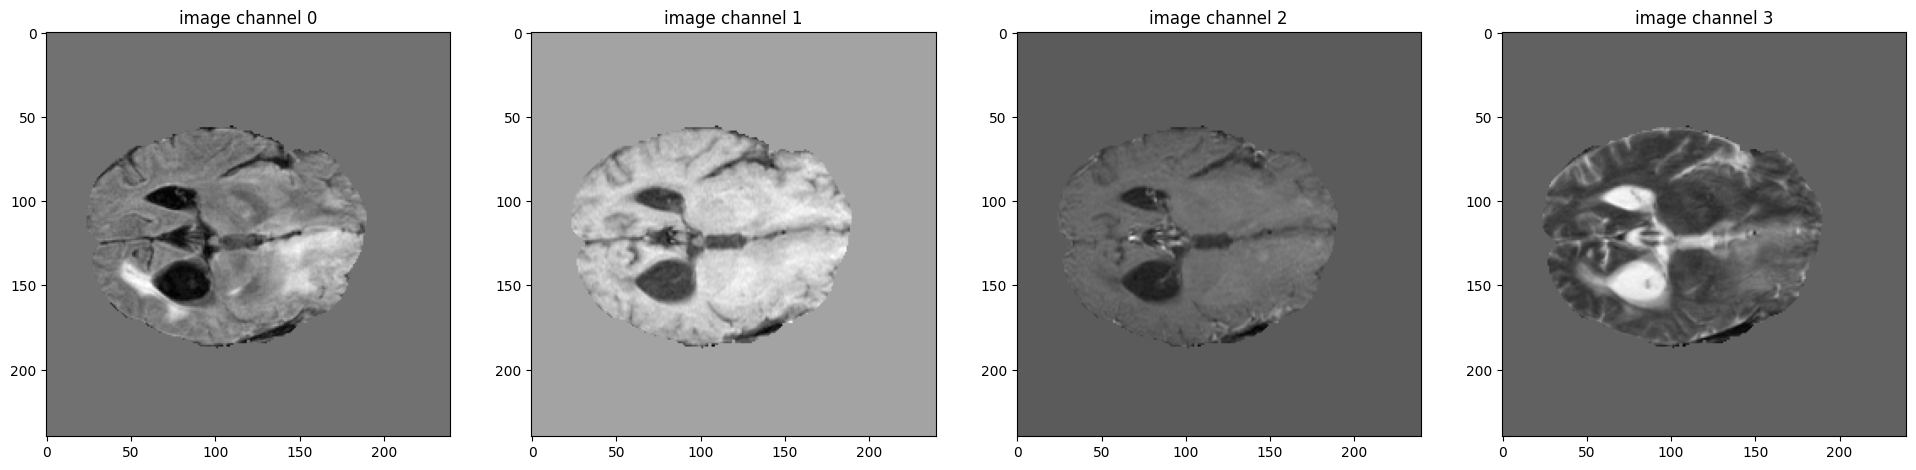

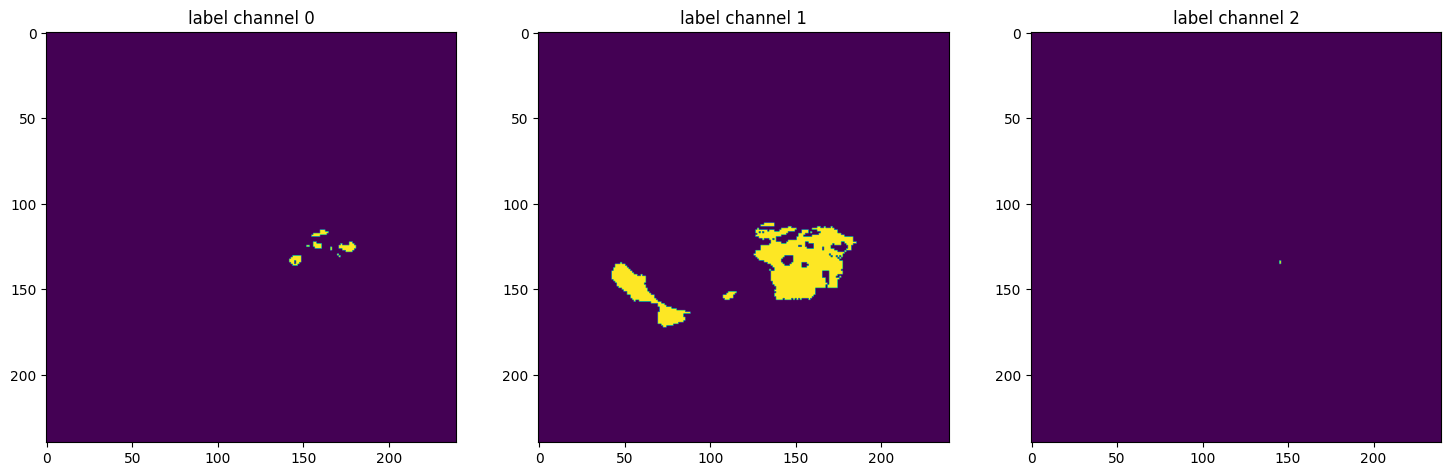

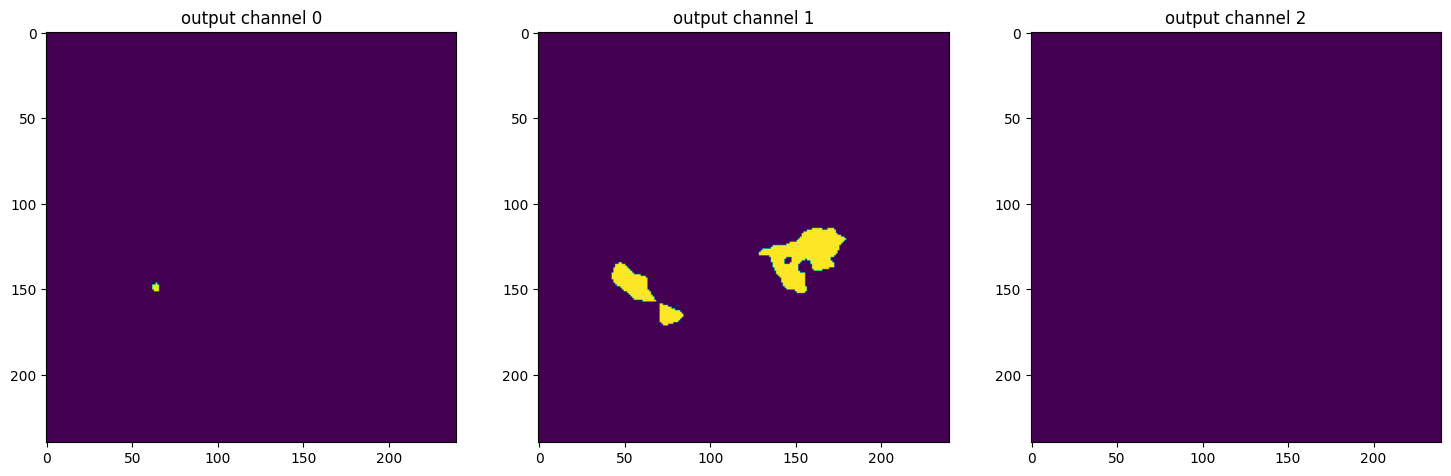

In [113]:
with torch.no_grad():
    # select one image to evaluate and visualize the model output
    sl=60
    n_case=22
    val_input = val_ds[n_case]["image"].unsqueeze(0).to(device)
    roi_size = (128, 128, 64)
    sw_batch_size = 4
    val_output = inference(val_input, model)
    val_output = post_trans(val_output[0])
    plt.figure("image", (24, 6))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.title(f"image channel {i}")
        plt.imshow(val_ds[n_case]["image"][i, :, :, sl].detach().cpu(), cmap="gray")
    plt.show()
    # visualize the 3 channels label corresponding to this image
    plt.figure("label", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"label channel {i}")
        plt.imshow(val_ds[n_case]["label"][i, :, :, sl].detach().cpu())
    plt.show()
    # visualize the 3 channels model output corresponding to this image
    plt.figure("output", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"output channel {i}")
        plt.imshow(val_output[i, :, :, sl].detach().cpu())
    plt.show()

In [108]:
root_dir=config.RAW_DATA_SET

val_org_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(1.0, 1.0, 1.0), mode="bilinear"),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)

val_org_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=val_org_transforms,
    section="validation",
    download=False,
    num_workers=2,
    cache_num=0,
)
val_org_loader = DataLoader(val_org_ds, batch_size=1, shuffle=False, num_workers=2)

post_transforms = Compose(
    [
        Invertd(
            keys="pred",
            transform=val_org_transforms,
            orig_keys="image",
            meta_keys="pred_meta_dict",
            orig_meta_keys="image_meta_dict",
            meta_key_postfix="meta_dict",
            nearest_interp=False,
            to_tensor=True,
            device="cpu",
        ),
        Activationsd(keys="pred", sigmoid=True),
        AsDiscreted(keys="pred", threshold=0.5),
    ]
)

In [ ]:
with torch.no_grad():
    for val_data in val_org_loader:
        val_inputs = val_data["image"].to(device)
        val_data["pred"] = inference(val_inputs, model)
        val_data = [post_transforms(i) for i in decollate_batch(val_data)]
        val_outputs, val_labels = from_engine(["pred", "label"])(val_data)
        dice_metric(y_pred=val_outputs, y=val_labels)
        dice_metric_batch(y_pred=val_outputs, y=val_labels)

    metric_org = dice_metric.aggregate().item()
    metric_batch_org = dice_metric_batch.aggregate()

    dice_metric.reset()
    dice_metric_batch.reset()

metric_tc, metric_wt, metric_et = metric_batch_org[0].item(), metric_batch_org[1].item(), metric_batch_org[2].item()

print("Metric on original image spacing: ", metric_org)
print(f"metric_tc: {metric_tc:.4f}")
print(f"metric_wt: {metric_wt:.4f}")
print(f"metric_et: {metric_et:.4f}")

In [79]:
from src.get_data import get_file_data_label

# Get train and validation dataset.
# train_files and val_files are a List[Dict] ->[{'image':[paths of MRI volumes], 'label':[path of label volume]}
modalities=['FLAIR.','T1.','T1GD.','T2.',]

train_files= get_file_data_label(config.DATA_TRAIN, config.LABEL_TRAIN, modalities)
val_files=get_file_data_label(config.CASE_TEST, config.LABEL_TEST, modalities)

print('Number of Train cases:',len(train_files))
print('Number of Modalities by cases:',len(train_files[0]['image']))
print('Number of Validation cases:',len(val_files))
print('Number of Modalities by cases:',len(val_files[0]['image']))

Number of Train cases: 10
Number of Modalities by cases: 4
Number of Validation cases: 1
Number of Modalities by cases: 4


In [82]:
val_transform = Compose(
    [
        LoadImaged(keys=["image", "label"],allow_missing_keys=True),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)

c:\Users\Cecilia\AppData\Local\pypoetry\Cache\virtualenvs\unsup-seg-gbm-nLgqUjZ0-py3.11\Lib\site-packages\monai\utils\deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)


In [83]:

# Create iterable Dataset and its Dataloader for Data validation
val_ds = Dataset(data=val_files,transform=val_transform, )
val_loader = DataLoader(val_ds, batch_size=1,) #num_workers=8

In [100]:
from monai.transforms import LoadImage

In [ ]:
image_path=val_files[0]['image'][0]


# Create a dictionary with the image file path
data = {"image": image_path}  # Replace with the actual file path

# Define the transforms to apply (in this case, only loading the image)
transforms = LoadImage(keys="image")

# Apply the transforms to load the image
output_data = transforms(data)

# Get the loaded image from the output_data dictionary
loaded_image = output_data["image"]

In [81]:
with torch.no_grad():
    # select one image to evaluate and visualize the model output
    sl=60
    n_case=0
    val_input = val_ds[n_case]["image"].unsqueeze(0).to(device)
    roi_size = (128, 128, 64)
    sw_batch_size = 4
    val_output = inference(val_input, model)
    val_output = post_trans(val_output[0])
    plt.figure("image", (24, 6))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.title(f"image channel {i}")
        plt.imshow(val_ds[n_case]["image"][i, :, :, sl].detach().cpu(), cmap="gray")
    plt.show()
    # visualize the 3 channels label corresponding to this image
    plt.figure("label", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"label channel {i}")
        plt.imshow(val_ds[n_case]["label"][i, :, :, sl].detach().cpu())
    plt.show()
    # visualize the 3 channels model output corresponding to this image
    plt.figure("output", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"output channel {i}")
        plt.imshow(val_output[i, :, :, sl].detach().cpu())
    plt.show()

RuntimeError: applying transform <monai.transforms.compose.Compose object at 0x000002C01385A690>